## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
import re
import warnings
warnings.filterwarnings('ignore')

## Load and Explore Data

In [3]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [4]:
print("Movies Dataset Shape:", movies.shape)
print("Ratings Dataset Shape:", ratings.shape)

Movies Dataset Shape: (62423, 3)
Ratings Dataset Shape: (25000095, 4)


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


## Data Preprocessing

In [7]:
def clean_title(title):
    return re.sub("[^a-zA-Z0-9 ]", "", title)

In [8]:
# Process movies data
movies_clean = movies.copy()
movies_clean['title'] = movies_clean['title'].apply(clean_title)
movies_clean['genres'] = movies_clean['genres'].str.split('|')

In [9]:
movies_clean = movies_clean[~movies_clean['genres'].apply(lambda x: '(no genres listed)' in x)]

In [10]:
movies_clean['genres_text'] = movies_clean['genres'].apply(lambda x: ' '.join(x))

In [11]:
ratings_clean = ratings.drop(['timestamp'], axis=1)

In [12]:
print(f"Clean Movies Dataset: {movies_clean.shape[0]} movies")
print(f"Clean Ratings Dataset: {ratings_clean.shape[0]} ratings")
print(f"Unique Users: {ratings_clean['userId'].nunique()}")

Clean Movies Dataset: 57361 movies
Clean Ratings Dataset: 25000095 ratings
Unique Users: 162541


## Exploratory Data Analysis

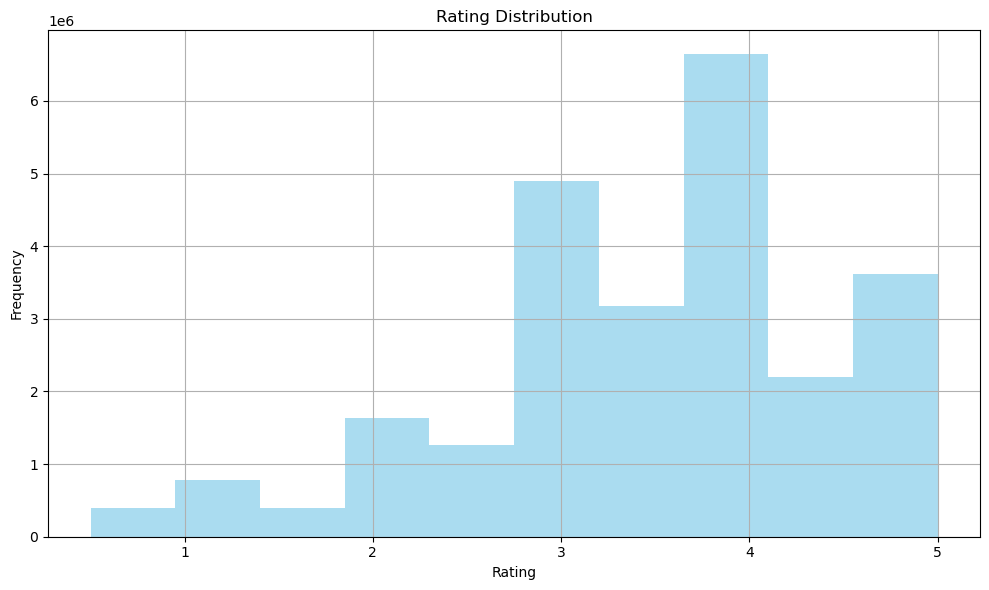

In [13]:
plt.figure(figsize=(10, 6))
ratings_clean['rating'].hist(bins=10, color='skyblue', alpha=0.7)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

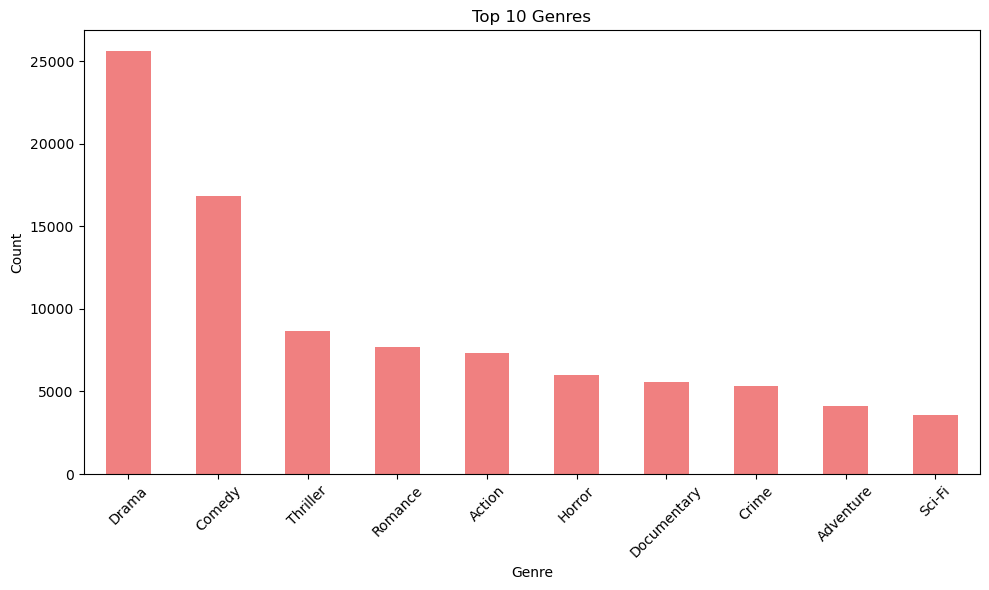

In [14]:
plt.figure(figsize=(10, 6))
all_genres = [genre for genres_list in movies_clean['genres'] for genre in genres_list]
genre_counts = pd.Series(all_genres).value_counts().head(10)
genre_counts.plot(kind='bar', color='lightcoral')
plt.title('Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Create Combined Dataset

In [15]:
combined_data = ratings_clean.merge(movies_clean[['movieId', 'title', 'genres_text']], on='movieId')
print("Combined Dataset Shape:", combined_data.shape)

Combined Dataset Shape: (24973468, 5)


In [16]:
combined_data.head()

,userId,movieId,rating,title,genres_text
0,1,296,5.0,Pulp Fiction 1994,Comedy Crime Drama Thriller
1,1,306,3.5,Three Colors Red Trois couleurs Rouge 1994,Drama
2,1,307,5.0,Three Colors Blue Trois couleurs Bleu 1993,Drama
3,1,665,5.0,Underground 1995,Comedy Drama War
4,1,899,3.5,Singin in the Rain 1952,Comedy Musical Romance


## Content-Based Recommendation System

In [17]:
class ContentBasedRecommender:
    def __init__(self, movies_data):
        self.movies_data = movies_data
        self.setup_vectorizers()

    def setup_vectorizers(self):
        # Title-based vectorizer
        self.title_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
        self.title_tfidf = self.title_vectorizer.fit_transform(self.movies_data['title'])

        # Genre-based vectorizer
        self.genre_vectorizer = TfidfVectorizer(ngram_range=(1,2))
        self.genre_tfidf = self.genre_vectorizer.fit_transform(self.movies_data['genres_text'])

    def search_by_title(self, title, top_n=5):
        title = clean_title(title)
        query_vec = self.title_vectorizer.transform([title])
        similarity = cosine_similarity(query_vec, self.title_tfidf).flatten()
        indices = np.argpartition(similarity, -top_n)[-top_n:]
        results = self.movies_data.iloc[indices][::-1]
        return results[['movieId', 'title', 'genres']]

    def recommend_by_genre(self, genres_text, top_n=10):
        query_vec = self.genre_vectorizer.transform([genres_text])
        similarity = cosine_similarity(query_vec, self.genre_tfidf).flatten()
        indices = np.argpartition(similarity, -top_n)[-top_n:]
        results = self.movies_data.iloc[indices][::-1]
        return results[['movieId', 'title', 'genres']]

In [18]:
content_recommender = ContentBasedRecommender(movies_clean)

## Collaborative Filtering Recommendation System

In [19]:
class CollaborativeRecommender:
    def __init__(self, combined_data):
        self.combined_data = combined_data
        self.movies_data = combined_data[['movieId', 'title', 'genres_text']].drop_duplicates()

    def get_user_similarity_scores(self, movie_id, min_rating=4.0):
        # Find users who rated this movie highly
        similar_users = self.combined_data[
            (self.combined_data['movieId'] == movie_id) &
            (self.combined_data['rating'] >= min_rating)
        ]['userId'].unique()

        if len(similar_users) == 0:
            return pd.Series(dtype=float)

        # Get movies these users also liked
        similar_user_movies = self.combined_data[
            (self.combined_data['userId'].isin(similar_users)) &
            (self.combined_data['rating'] >= min_rating)
        ]['movieId'].value_counts(normalize=True)

        # Get general popularity of these movies
        all_user_movies = self.combined_data[
            (self.combined_data['movieId'].isin(similar_user_movies.index)) &
            (self.combined_data['rating'] >= min_rating)
        ]['movieId'].value_counts(normalize=True)

        # Calculate recommendation score
        scores = pd.DataFrame({
            'similar_users': similar_user_movies,
            'all_users': all_user_movies
        }).fillna(0)

        scores['recommendation_score'] = np.where(
            scores['all_users'] > 0,
            scores['similar_users'] / scores['all_users'],
            0
        )

        return scores['recommendation_score'].sort_values(ascending=False)

    def recommend_movies(self, movie_title, top_n=10):
        movie_matches = content_recommender.search_by_title(movie_title, 1)
        if movie_matches.empty:
            return pd.DataFrame()

        movie_id = movie_matches.iloc[0]['movieId']
        scores = self.get_user_similarity_scores(movie_id)
        if scores.empty:
            return pd.DataFrame()

        recommendations = scores.head(top_n).reset_index()
        recommendations.columns = ['movieId', 'score']
        recommendations = recommendations.merge(self.movies_data, on='movieId')

        return recommendations[['title', 'genres_text', 'score']].round(4)

In [20]:
collab_recommender = CollaborativeRecommender(combined_data)

## Hybrid Recommendation System

In [21]:
class HybridRecommender:
    def __init__(self, content_recommender, collab_recommender, combined_data):
        self.content_rec = content_recommender
        self.collab_rec = collab_recommender
        self.combined_data = combined_data

    def hybrid_recommend(self, movie_title, top_n=10, content_weight=0.3, collab_weight=0.7):
        movie_matches = self.content_rec.search_by_title(movie_title, 1)
        if movie_matches.empty:
            print(f"No movie found matching '{movie_title}'")
            return pd.DataFrame()

        movie_id = movie_matches.iloc[0]['movieId']
        selected_movie = movie_matches.iloc[0]

        print(f"Selected Movie: {selected_movie['title']}")
        print(f"Genres: {', '.join(selected_movie['genres'])}")
        print("-" * 50)

        genres_text = ' '.join(selected_movie['genres'])
        content_recs = self.content_rec.recommend_by_genre(genres_text, top_n*2)
        content_scores = pd.DataFrame({
            'movieId': content_recs['movieId'],
            'content_score': np.linspace(1.0, 0.1, len(content_recs))
        })

        collab_scores = self.collab_rec.get_user_similarity_scores(movie_id)
        if not collab_scores.empty:
            collab_df = pd.DataFrame({
                'movieId': collab_scores.index,
                'collab_score': collab_scores.values
            })
        else:
            collab_df = pd.DataFrame(columns=['movieId', 'collab_score'])

        all_movies = pd.merge(content_scores, collab_df, on='movieId', how='outer').fillna(0)
        all_movies['hybrid_score'] = (
            content_weight * all_movies['content_score'] +
            collab_weight * all_movies['collab_score']
        )

        top_recommendations = all_movies.nlargest(top_n, 'hybrid_score')

        movies_info = self.combined_data[['movieId', 'title', 'genres_text']].drop_duplicates()
        results = top_recommendations.merge(movies_info, on='movieId')

        results = results[results['movieId'] != movie_id]

        return results[['title', 'genres_text', 'hybrid_score', 'content_score', 'collab_score']].head(top_n)

In [22]:
hybrid_recommender = HybridRecommender(content_recommender, collab_recommender, combined_data)

## Test Recommendation Systems

In [23]:
def test_recommendations(movie_title):
    print(f"MOVIE RECOMMENDATIONS FOR: '{movie_title}'")
    print("-" * 60)

    # Content-based
    print("\nCONTENT-BASED RECOMMENDATIONS:")
    movie_matches = content_recommender.search_by_title(movie_title, 1)
    if not movie_matches.empty:
        selected_movie = movie_matches.iloc[0]
        genres_text = ' '.join(selected_movie['genres'])
        content_recs = content_recommender.recommend_by_genre(genres_text, 5)
        for i, (_, movie) in enumerate(content_recs.iterrows(), 1):
            print(f"{i}. {movie['title']} - {', '.join(movie['genres'])}")
    else:
        print("No content-based recommendations available")

    # Collaborative
    print("\nCOLLABORATIVE FILTERING RECOMMENDATIONS:")
    collab_recs = collab_recommender.recommend_movies(movie_title, 5)
    if not collab_recs.empty:
        for i, (_, movie) in enumerate(collab_recs.iterrows(), 1):
            print(f"{i}. {movie['title']} (Score: {movie['score']:.3f}) - {movie['genres_text']}")
    else:
        print("No collaborative recommendations available")

    # Hybrid
    print("\nHYBRID RECOMMENDATIONS:")
    hybrid_recs = hybrid_recommender.hybrid_recommend(movie_title, 5)
    if not hybrid_recs.empty:
        for i, (_, movie) in enumerate(hybrid_recs.iterrows(), 1):
            print(f"{i}. {movie['title']} (Score: {movie['hybrid_score']:.3f}) - {movie['genres_text']}")
    else:
        print("No hybrid recommendations available")


# Test
test_movies = ["Toy Story", "The Matrix", "Titanic", "Star Wars"]
for movie in test_movies:
    test_recommendations(movie)
    print("\n" + "="*80 + "\n")


MOVIE RECOMMENDATIONS FOR: 'Toy Story'
------------------------------------------------------------

CONTENT-BASED RECOMMENDATIONS:
1. Ant Bully The 2006 - Adventure, Animation, Children, Comedy, Fantasy, IMAX
2. Shrek Forever After aka Shrek The Final Chapter 2010 - Adventure, Animation, Children, Comedy, Fantasy, IMAX
3. Toy Story 3 2010 - Adventure, Animation, Children, Comedy, Fantasy, IMAX
4. Rise of the Guardians 2012 - Adventure, Animation, Children, Fantasy, IMAX
5. Polar Express The 2004 - Adventure, Animation, Children, Fantasy, IMAX

COLLABORATIVE FILTERING RECOMMENDATIONS:
1. Adrenalin The BMW Touring Car Story 2014 (Score: 7.158) - Documentary
2. The House Where Evil Dwells 1982 (Score: 7.158) - Horror
3. The Man in the Raincoat 1957 (Score: 7.158) - Comedy Mystery
4. Diaboliquement vtre 1967 (Score: 7.158) - Crime Drama Thriller
5. King 2008 (Score: 7.158) - Action Comedy Crime Documentary

HYBRID RECOMMENDATIONS:
Selected Movie: Toy Story 3 2010
Genres: Adventure, Animat

## Evaluation Metrics

In [24]:
def evaluate_recommendations():
    print("RECOMMENDATION SYSTEM EVALUATION")
    print("=" * 50)

    # Dataset statistics
    print("DATASET STATISTICS:")
    print(f"Total Movies: {movies_clean.shape[0]:,}")
    print(f"Total Ratings: {ratings_clean.shape[0]:,}")
    print(f"Total Users: {ratings_clean['userId'].nunique():,}")
    print(f"Average Rating: {ratings_clean['rating'].mean():.2f}")
    print(f"Rating Range: {ratings_clean['rating'].min():.1f} - {ratings_clean['rating'].max():.1f}")

    all_genres = set([genre for genres_list in movies_clean['genres'] for genre in genres_list])
    print(f"Total Genres: {len(all_genres)}")

    # Movie popularity
    movie_rating_counts = combined_data.groupby('movieId')['rating'].count()
    print("\nMOVIE POPULARITY:")
    print(f"Movies with 1 rating: {(movie_rating_counts == 1).sum():,}")
    print(f"Movies with 10+ ratings: {(movie_rating_counts >= 10).sum():,}")
    print(f"Movies with 100+ ratings: {(movie_rating_counts >= 100).sum():,}")

    # User activity
    user_rating_counts = combined_data.groupby('userId')['rating'].count()
    print("\nUSER ACTIVITY:")
    print(f"Users with 1 rating: {(user_rating_counts == 1).sum():,}")
    print(f"Users with 10+ ratings: {(user_rating_counts >= 10).sum():,}")
    print(f"Users with 100+ ratings: {(user_rating_counts >= 100).sum():,}")

# Run evaluation
evaluate_recommendations()


RECOMMENDATION SYSTEM EVALUATION
DATASET STATISTICS:
Total Movies: 57,361
Total Ratings: 25,000,095
Total Users: 162,541
Average Rating: 3.53
Rating Range: 0.5 - 5.0
Total Genres: 19

MOVIE POPULARITY:
Movies with 1 rating: 8,458
Movies with 10+ ratings: 24,010
Movies with 100+ ratings: 10,303

USER ACTIVITY:
Users with 1 rating: 0
Users with 10+ ratings: 162,541
Users with 100+ ratings: 63,880


## Save models

In [25]:
import pickle

# Save Content-Based model
with open("content_recommender.pkl", "wb") as f:
    pickle.dump(content_recommender, f)

# Save Collaborative model
with open("collab_recommender.pkl", "wb") as f:
    pickle.dump(collab_recommender, f)

# Save Hybrid model
with open("hybrid_recommender.pkl", "wb") as f:
    pickle.dump(hybrid_recommender, f)

print("Models have been saved successfully!")

Models have been saved successfully!
